# <center> HW 5 -- Recover Einstein </center>

&copy; 2023 Kaiwen Zhou

# Load Libraries and Packages

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # for loading images 
from scipy.ndimage.interpolation import zoom  # for scaling images


fname = 'einstein.jpg'
i_width = 640
i_height = 480

# Load the Einstein Image

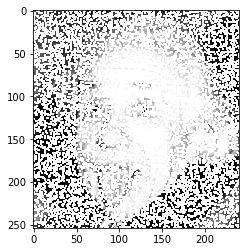

(254, 240)

In [47]:
# load image and zoom in 5x to get a (254, 240) image with value in [0,255]
image = zoom(np.asarray(Image.open(fname).convert("L")), 0.2).astype(np.float)
image_ss = image.copy()
np.random.seed(42)

# uniformly sample and wipe out 0.2*N pixels with shape = image.shape
# here used one property of the uniform distribution
# P(X<p) = p  ===> N*P(X<p) = N*p = 0.2*N
sampling_threshold = 0.8
mask = np.random.uniform(size=image.shape) < 1- sampling_threshold
image_ss[mask] = np.nan

# visualize the subsampled image 
plt.imshow(image_ss, cmap='gray', vmin=0, vmax=255)
plt.show()
image_ss.shape

# Question 1

# Formualte the Problem

One can think of this as a supervised learning problem as follows. Suppose $y = f(x) := f(i,j) = image_{ss}(i,j)$ be the pixel value of the image at position $x = (i,j)$. Filling-in the missing values of the matrix can be thought of as a supervised learning problem where one learns the function $f(x) = f(i,j)$ based on training on the available pixels and their locations.

Let the training data $y_{train}, X_{train}$ consist of all available non-$N/A$ pixel values and their positions, while the testing positions $X_{test}$ be those of the missing pixels. Filling the missing value of the matrix can then be thought as a supervised learning problem where one learns the function $f(i,j)$ which produces the pixel value as a function of location.

That is, 
<table>
<tr><th> X_train </th><th>y_train</th></tr>
<tr><td>
    
|       |x_position|y_position|
| ---   | ---      | ---      |
|1      |x_1       |y_1       |
|2      |x_2       |y_2       |
|3      |x_3       |y_3       |
|4      |x_4       |y_4       |
|5      |x_5       |y_5       |
</td><td>
    
|       |values|
| ---   | ---  |
|1      |v_1   |
|2      |v_2   |
|3      |v_3   |
|4      |v_4   |
|5      |v_5   |
</td></tr> </table>

# (a) Construct $y_{train},X_{train}$ and $X_{test}, y_{test}$

In [86]:
X_train = []
y_train = []
X_test = []

# y_test here contains true values that were assigned np.nan in the 
# previous step
y_test = []  

for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            X_test.append([i,j])
            y_test.append(image[i][j])
        else:
            X_train.append([i,j])
            y_train.append(image_ss[i][j])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train, y_train, X_test, y_test

(array([[  0,   0],
        [  0,   1],
        [  0,   2],
        ...,
        [253, 237],
        [253, 238],
        [253, 239]]),
 array([84., 89., 98., ..., 26., 57., 51.]),
 array([[  0,   4],
        [  0,   5],
        [  0,   6],
        ...,
        [253, 212],
        [253, 215],
        [253, 225]]),
 array([ 84.,  78.,  82., ...,  85.,  44., 103.]))

# (b) Try Three Different Regression Models

In [57]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


### Try RandomForrestRegresor

In [104]:
from sklearn.ensemble import RandomForestRegressor

# Dictionary containing grid Hyperparameters
grid_params = {
    'RandomForest__max_depth': [1,2,3, None],
    'RandomForest__n_estimators': [10, 100, 200]
}

# Build Pipeline
gs_RandomForest = GridSearchCV(
    Pipeline([('RandomForest', RandomForestRegressor(random_state=42,
                                                     criterion='friedman_mse',
                                                     n_jobs=2             # use all processors  
                                        )
            )
    ]),
    grid_params,
    scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
    verbose = 4,  # set to 1 is equivalent to no bs
    cv = 5,       # (Stratified) 5-Fold Cross-Validation
    n_jobs=2      # use 2 processors
)


# Fit the train_set
gs_RandomForest_results = gs_RandomForest.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [105]:
gs_RandomForest_results.best_score_

-4341.336961278426

In [106]:
gs_RandomForest_results.best_estimator_

Pipeline(steps=[('RandomForest',
                 RandomForestRegressor(criterion='friedman_mse',
                                       n_estimators=10, n_jobs=2,
                                       random_state=42))])

In [107]:
gs_RandomForest_results.best_params_

{'RandomForest__max_depth': None, 'RandomForest__n_estimators': 10}

### Try GradientBoostingRegressor

In [114]:
from sklearn.ensemble import GradientBoostingRegressor

# Dictionary containing grid Hyperparameters
grid_params = {
    'GradientBoosting__max_depth': [1, None],
    'GradientBoosting__n_estimators': [10, 100, 200],
    'GradientBoosting__learning_rate': [0.01,0.3, 0.8]
    
}

# Build Pipeline
gs_GradientBoosting = GridSearchCV(
    Pipeline([('GradientBoosting', GradientBoostingRegressor(random_state=42,
                                                             loss='squared_error',
                                                             criterion='friedman_mse',
                                        )
            )
    ]),
    grid_params,
    scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
    verbose = 4,  # set to 1 is equivalent to no bs
    cv = 5,       # (Stratified) 5-Fold Cross-Validation
    n_jobs=2      # use 2 processors
)


# Fit the train_set
gs_GradientBoosting_results = gs_GradientBoosting.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [115]:
gs_GradientBoosting_results.best_score_

-3905.762957578632

In [116]:
gs_GradientBoosting_results.best_estimator_

Pipeline(steps=[('GradientBoosting',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=None,
                                           random_state=42))])

In [117]:
gs_GradientBoosting_results.best_params_

{'GradientBoosting__learning_rate': 0.01,
 'GradientBoosting__max_depth': None,
 'GradientBoosting__n_estimators': 100}

### Try SVM Regression with RBF feature map transform

In [100]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

# Dictionary containing grid Hyperparameters
grid_params = {
    'SVR__C': [0.1, 1, 10]
}

# Build Pipeline
gs_SVR = GridSearchCV(
    Pipeline([('MinMaxScaler', MinMaxScaler()),
              ('SVR', SVR(kernel='rbf'))
    ]),
    grid_params,
    scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
    verbose = 4,  # set to 1 is equivalent to no bs
    cv = 5,       # (Stratified) 5-Fold Cross-Validation
    n_jobs=2      # use 2 processors
)


# Fit the train_set
gs_SVR_results = gs_SVR.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [101]:
gs_SVR_results.best_score_

-3900.31221849664

In [102]:
gs_SVR_results.best_estimator_

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('SVR', SVR(C=10))])

In [103]:
gs_SVR_results.best_params_

{'SVR__C': 10}

[CV 1/5] END ....................SVR__C=0.1;, score=-4527.092 total time= 2.0min
[CV 3/5] END ....................SVR__C=0.1;, score=-3237.143 total time= 2.0min
[CV 5/5] END ....................SVR__C=0.1;, score=-6501.401 total time= 1.9min
[CV 2/5] END ......................SVR__C=1;, score=-2347.984 total time= 1.8min
[CV 4/5] END ......................SVR__C=1;, score=-4511.237 total time= 1.8min
[CV 2/5] END .....................SVR__C=10;, score=-1603.144 total time= 1.8min
[CV 4/5] END .....................SVR__C=10;, score=-3305.971 total time= 1.8min
[CV 2/5] END ....................SVR__C=0.1;, score=-3264.410 total time= 2.0min
[CV 4/5] END ....................SVR__C=0.1;, score=-5540.907 total time= 2.0min
[CV 1/5] END ......................SVR__C=1;, score=-3018.834 total time= 1.9min
[CV 3/5] END ......................SVR__C=1;, score=-3895.245 total time= 1.8min
[CV 5/5] END ......................SVR__C=1;, score=-6245.724 total time= 1.8min
[CV 1/5] END ...............

### Try 2 − D Gaussian kernel feature map regression

where each of your feature maps is $\varphi_\sigma(x, x_0) = exp(-|x-x_0|2/2\sigma^2)$ and you have rescaled your image pixel locations so that $x, x_0 \in [0, 1]^2$.'squared_error'

In [127]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

sigma = X_train.var()  # get the sigma term for the kernel

# Dictionary containing grid Hyperparameters
grid_params = {
    'RBF__gamma': [1/(2*sigma**2), 1, 'scale', 0.7, 2]
}

# Build Pipeline for GKFMR -- Gaussian Kernel Feature Map Regression
gs_GKFMR = GridSearchCV(
    Pipeline([('MinMaxScaler', MinMaxScaler()),
              ('RBF', RBFSampler(random_state=42,
                                 n_components=100
                                )
              ),
              ('LinearRegression', LinearRegression(n_jobs=2))
    ]),
    grid_params,
    scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
    verbose = 4,  # set to 1 is equivalent to no bs
    cv = 5,       # (Stratified) 5-Fold Cross-Validation
    n_jobs=2      # use 2 processors
)


# Fit the train_set
gs_GKFMR_results = gs_GKFMR.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [128]:
gs_GKFMR_results.best_score_

-6687.709280885065

In [129]:
gs_GKFMR_results.best_estimator_

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('RBF',
                 RBFSampler(gamma=1.9218945227556606e-08, random_state=42)),
                ('LinearRegression', LinearRegression(n_jobs=2))])

In [130]:
gs_GKFMR_results.best_params_

{'RBF__gamma': 1.9218945227556606e-08}

**The best cross-validation score for each model is:**

| model  |  5-Fold CV score  |
|---|----|
|RandomForrestRegresor |4341.336961278426|
|GradientBoostingRegressor|3905.762957578632|
|SVM with RBF|3900.31221849664|
|RBF with Least Squares|6687.709280885065|

We can clearly see that **GradientBoostingRegressor and SVM give the best cross-validation score.**

# (c) 

### Predict $\hat{y}_{test}$ and compare it with the true $y_{test}$

In [131]:
from sklearn.metrics import mean_squared_error

##################### Random Forest
RF_optimal = RandomForestRegressor(random_state=42,
                                   max_depth=None,
                                   n_estimators=10,
                                   criterion='friedman_mse',
                                   n_jobs=2  # use all processors  
                                        )
RF_optimal.fit(X_train, y_train)
RF_y_pred = RF_optimal.predict(X_test)

##################### GradientBoosting
GB_optimal = GradientBoostingRegressor(random_state=42,
                                       learning_rate=0.01,
                                       loss='squared_error',
                                       max_depth=None,
                                       n_estimators=100,
                                       criterion='friedman_mse',
                                      )
GB_optimal.fit(X_train, y_train)
GB_y_pred = GB_optimal.predict(X_test)

##################### SVM with RBF
SVR_optimal = Pipeline([('MinMaxScaler', MinMaxScaler()),
                        ('SVR', SVR(kernel='rbf', C=10))
                    ])
SVR_optimal.fit(X_train, y_train)
SVR_y_pred = SVR_optimal.predict(X_test)

##################### RBF with Least Squares
GKFMR_optimal = Pipeline([('MinMaxScaler', MinMaxScaler()),
              ('RBF', RBFSampler(random_state=42,
                                 n_components=100,
                                 gamma=1.9218945227556606e-08
                                )
              ),
              ('LinearRegression', LinearRegression(n_jobs=2))
    ])
GKFMR_optimal.fit(X_train, y_train)
GKFMR_y_pred = GKFMR_optimal.predict(X_test)

print('the resulting MSE for the RandomForestRegressor is ', mean_squared_error(RF_y_pred, y_test))
print('the resulting MSE for the GradientBoostingRegressor is ', mean_squared_error(GB_y_pred, y_test))
print('the resulting MSE for the SVM with RBF is ', mean_squared_error(SVR_y_pred, y_test))
print('the resulting MSE for the RBF with Least Squares is ', mean_squared_error(GKFMR_y_pred, y_test))


[CV 1/5] END RBF__gamma=1.9218945227556606e-08;, score=-7791.767 total time=   0.3s
[CV 3/5] END RBF__gamma=1.9218945227556606e-08;, score=-3105.595 total time=   0.3s
[CV 5/5] END RBF__gamma=1.9218945227556606e-08;, score=-13951.867 total time=   0.3s
[CV 2/5] END ..................RBF__gamma=1;, score=-3788.096 total time=   0.3s
[CV 4/5] END ..................RBF__gamma=1;, score=-3101.980 total time=   0.3s
[CV 1/5] END ....................RBF__gamma=scale;, score=nan total time=   0.0s
[CV 2/5] END ....................RBF__gamma=scale;, score=nan total time=   0.0s
[CV 3/5] END ....................RBF__gamma=scale;, score=nan total time=   0.0s
[CV 5/5] END ....................RBF__gamma=scale;, score=nan total time=   0.0s
[CV 2/5] END RBF__gamma=1.9218945227556606e-08;, score=-3474.209 total time=   0.4s
[CV 3/5] END RBF__gamma=1.9218945227556606e-08;, score=-3105.595 total time=   0.3s
[CV 5/5] END RBF__gamma=1.9218945227556606e-08;, score=-13951.867 total time=   0.3s
[CV 2/5]

| model  |  MSE to true missing values  |
|---|----|
|RandomForrestRegresor |173.29370864197531|
|GradientBoostingRegressor|1346.0359792950533|
|SVM with RBF|1913.0319161316079|
|RBF with Least Squares|4397.70304526749|

We can clearly see that the **RandomForrestRegresor produces a result closest to the true image.**

### Plot the completed images for each of your four optimal models

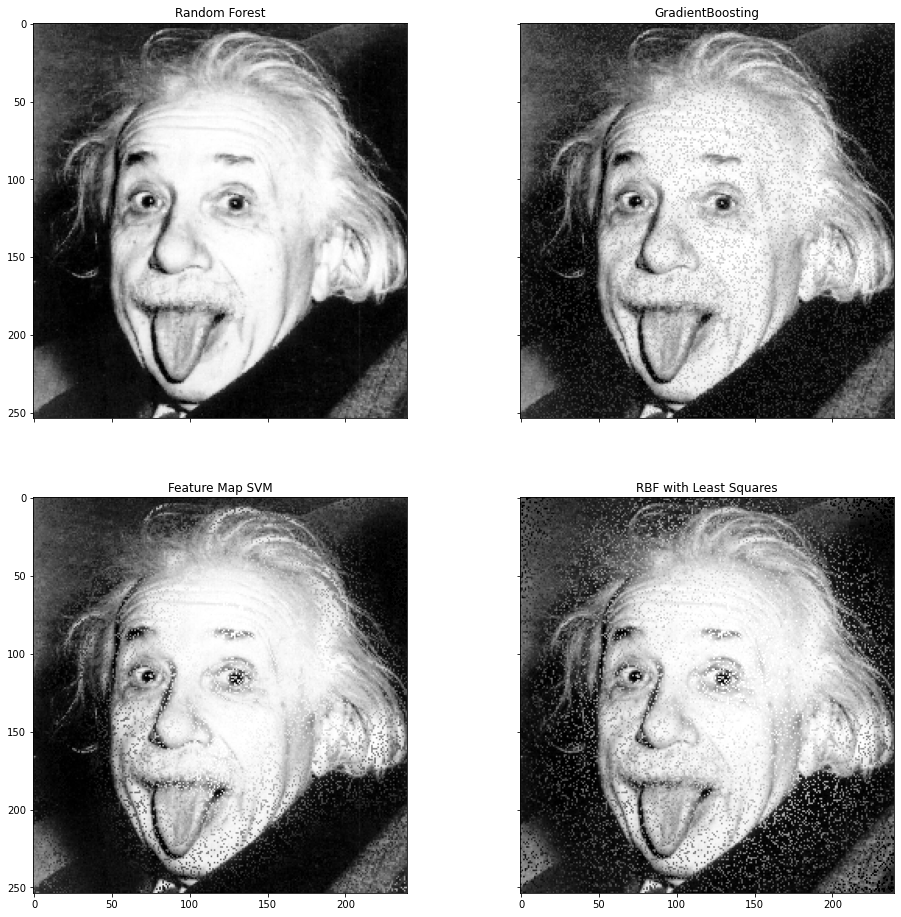

In [144]:
##################### Random Forest
RF_image = image_ss.copy()
k=0
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            RF_image[i][j]=RF_y_pred[k]
            k+=1
            

##################### GradientBoosting
GB_image = image_ss.copy()
k=0
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            GB_image[i][j]=GB_y_pred[k]
            k+=1

            
##################### SVM with RBF
SVR_image = image_ss.copy()
k=0
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            SVR_image[i][j]=SVR_y_pred[k]
            k+=1

##################### RBF with Least Squares
GKFMR_image = image_ss.copy()
k=0
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            GKFMR_image[i][j]=GKFMR_y_pred[k]
            k+=1

                       
############ visualize the recovered image 
fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharex=True, sharey=True)
axs[0,0].set_title('Random Forest')
axs[0,0].imshow(RF_image, cmap='gray', vmin=0, vmax=255)
axs[0,1].set_title('GradientBoosting')
axs[0,1].imshow(GB_image, cmap='gray', vmin=0, vmax=255)
axs[1,0].set_title('Feature Map SVM')
axs[1,0].imshow(SVR_image, cmap='gray', vmin=0, vmax=255)
axs[1,1].set_title('RBF with Least Squares')
axs[1,1].imshow(GKFMR_image, cmap='gray', vmin=0, vmax=255)
plt.show()

We can see both images produced by **the RandomForest is pretty smooth**, while the ones produced by the other three are all sort of gritty.

# (d) 

### Investigate the effect of adding an L1 − L2 elastic net regularization to the 2 − D Gaussian kernel feature map regression

In [136]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet
import warnings
warnings.filterwarnings('ignore')

sigma = X_train.var()  # get the sigma term for the kernel

# Dictionary containing grid Hyperparameters
grid_params = {
    'RBF__gamma': [1/(2*sigma**2), 1, 'scale'],
    'ElasticNet__alpha': [0.5, 1, 2],
    'ElasticNet__l1_ratio': [0.3, 0.5, 0.8]
}

# Build Pipeline for RBF_ElasticNet (regularized RBF with Least Squares)
gs_RBF_ElasticNet = GridSearchCV(
    Pipeline([('MinMaxScaler', MinMaxScaler()),
              ('RBF', RBFSampler(random_state=42,
                                 n_components=100
                                )
              ),
              ('ElasticNet', ElasticNet(random_state=42)
              )
    ]),
    grid_params,
    scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
    verbose = 4,  # set to 1 is equivalent to no bs
    cv = 5,       # (Stratified) 5-Fold Cross-Validation
    n_jobs=2      # use 2 processors
)


# Fit the train_set
gs_RBF_ElasticNet_results = gs_RBF_ElasticNet.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [137]:
gs_RBF_ElasticNet_results.best_score_

-9515.764135614523

In [138]:
gs_RBF_ElasticNet_results.best_estimator_

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('RBF',
                 RBFSampler(gamma=1.9218945227556606e-08, random_state=42)),
                ('ElasticNet',
                 ElasticNet(alpha=0.5, l1_ratio=0.3, random_state=42))])

In [139]:
gs_RBF_ElasticNet_results.best_params_

{'ElasticNet__alpha': 0.5,
 'ElasticNet__l1_ratio': 0.3,
 'RBF__gamma': 1.9218945227556606e-08}

[CV 1/5] END ElasticNet__alpha=0.5, ElasticNet__l1_ratio=0.3, RBF__gamma=1.9218945227556606e-08;, score=-5900.227 total time=   0.2s
[CV 3/5] END ElasticNet__alpha=0.5, ElasticNet__l1_ratio=0.3, RBF__gamma=1.9218945227556606e-08;, score=-10475.974 total time=   0.2s
[CV 5/5] END ElasticNet__alpha=0.5, ElasticNet__l1_ratio=0.3, RBF__gamma=1.9218945227556606e-08;, score=-10770.516 total time=   0.2s
[CV 2/5] END ElasticNet__alpha=0.5, ElasticNet__l1_ratio=0.3, RBF__gamma=1;, score=-10002.714 total time=   0.2s
[CV 4/5] END ElasticNet__alpha=0.5, ElasticNet__l1_ratio=0.3, RBF__gamma=1;, score=-9891.022 total time=   0.2s
[CV 1/5] END ElasticNet__alpha=0.5, ElasticNet__l1_ratio=0.3, RBF__gamma=scale;, score=nan total time=   0.0s
[CV 2/5] END ElasticNet__alpha=0.5, ElasticNet__l1_ratio=0.3, RBF__gamma=scale;, score=nan total time=   0.0s
[CV 4/5] END ElasticNet__alpha=0.5, ElasticNet__l1_ratio=0.3, RBF__gamma=scale;, score=nan total time=   0.0s
[CV 1/5] END ElasticNet__alpha=0.5, ElasticN

### Let's check the MSE to the true missing values

In [140]:
##################### RBF with ElasticNet
RBF_ElasticNet_optimal = Pipeline([('MinMaxScaler', MinMaxScaler()),
                                   ('RBF', RBFSampler(random_state=42,
                                                     n_components=100,
                                                     gamma=1.9218945227556606e-08
                                                    )
                                   ),
                                   ('ElasticNet', ElasticNet(random_state=42,
                                                            alpha=0.5,
                                                            l1_ratio=0.3
                                                           )
                                   )
                                ])
RBF_ElasticNet_optimal.fit(X_train, y_train)
RBF_ElasticNet_y_pred = RBF_ElasticNet_optimal.predict(X_test)

print('the resulting MSE for the RBF with ElasticNet is ', mean_squared_error(RBF_ElasticNet_y_pred, y_test))


the resulting MSE for the RBF with ElasticNet is  8654.471584967758


### Plot the recovered image generated by this algorithm

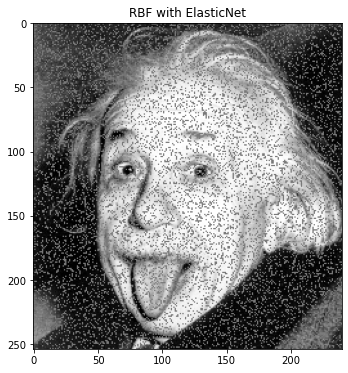

In [146]:
##################### RBF with ElasticNet
RBF_ElasticNet_image = image_ss.copy()
k=0
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            RBF_ElasticNet_image[i][j]=RBF_ElasticNet_y_pred[k]
            k+=1

fig = plt.figure(figsize=(6,6))
plt.title('RBF with ElasticNet')
plt.imshow(RBF_ElasticNet_image, cmap='gray', vmin=0, vmax=255)
plt.show()

**Very Gritty.**

# (e) 

### For this part, we are basically asked to reconstruct X_train and X_test

In [149]:
X_train = []
y_train = []
X_test = []

# y_test here contains true values that were assigned np.nan in the 
# previous step
y_test = []  

for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        try:
            y_up = image_ss[i-1][j] if not np.isnan(image_ss[i-1][j]) else -999
        except:
            y_up = -999
        try:
            y_dn = image_ss[i+1][j] if not np.isnan(image_ss[i+1][j]) else -999
        except:
            y_dn = -999
        try:
            y_l = image_ss[i][j-1] if not np.isnan(image_ss[i][j-1]) else -999
        except:
            y_l = -999
        try:
            y_r = image_ss[i][j+1] if not np.isnan(image_ss[i][j+1]) else -999
        except:
            y_r = -999
        if np.isnan(image_ss[i][j]):
            X_test.append([i,j,y_up,y_dn,y_l,y_r])
            
            y_test.append(image[i][j])
        else:
            X_train.append([i,j,y_up,y_dn,y_l,y_r])
            y_train.append(image_ss[i][j])
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train, y_train, X_test, y_test

(array([[   0.,    0.,   66.,  103., -999.,   89.],
        [   0.,    1.,   60.,   90.,   84.,   98.],
        [   0.,    2., -999.,   88.,   89.,   87.],
        ...,
        [ 253.,  237.,   31., -999.,   25.,   57.],
        [ 253.,  238., -999., -999.,   26.,   51.],
        [ 253.,  239.,   44., -999.,   57., -999.]]),
 array([84., 89., 98., ..., 26., 57., 51.]),
 array([[   0.,    4.,   50., -999.,   87., -999.],
        [   0.,    5.,   42.,   67., -999., -999.],
        [   0.,    6.,   42.,   75., -999.,   63.],
        ...,
        [ 253.,  212.,  124., -999.,   99.,   80.],
        [ 253.,  215.,   41., -999.,   80.,   94.],
        [ 253.,  225., -999., -999.,   99.,   82.]]),
 array([ 84.,  78.,  82., ...,  85.,  44., 103.]))

In [150]:
from sklearn.ensemble import RandomForestRegressor

# Dictionary containing grid Hyperparameters
grid_params = {
    'RandomForest__max_depth': [1,2,3, None],
    'RandomForest__n_estimators': [10, 100, 200]
}

# Build Pipeline
gs_RandomForest = GridSearchCV(
    Pipeline([('RandomForest', RandomForestRegressor(random_state=42,
                                                     criterion='friedman_mse',
                                                     n_jobs=2             # use all processors  
                                        )
            )
    ]),
    grid_params,
    scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
    verbose = 1,  # set to 1 is equivalent to no bs
    cv = 5,       # (Stratified) 5-Fold Cross-Validation
    n_jobs=2      # use 2 processors
)


# Fit the train_set
gs_RandomForest_results = gs_RandomForest.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [151]:
gs_RandomForest_results.best_score_

-176.16858386140137

In [152]:
gs_RandomForest_results.best_estimator_

Pipeline(steps=[('RandomForest',
                 RandomForestRegressor(criterion='friedman_mse',
                                       n_estimators=200, n_jobs=2,
                                       random_state=42))])

In [153]:
gs_RandomForest_results.best_params_

{'RandomForest__max_depth': None, 'RandomForest__n_estimators': 200}

### Try GradientBoostingRegressor

In [154]:
from sklearn.ensemble import GradientBoostingRegressor

# Dictionary containing grid Hyperparameters
grid_params = {
    'GradientBoosting__max_depth': [1, None],
    'GradientBoosting__n_estimators': [10, 100, 200],
    'GradientBoosting__learning_rate': [0.01,0.3, 0.8]
    
}

# Build Pipeline
gs_GradientBoosting = GridSearchCV(
    Pipeline([('GradientBoosting', GradientBoostingRegressor(random_state=42,
                                                             loss='squared_error',
                                                             criterion='friedman_mse',
                                        )
            )
    ]),
    grid_params,
    scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
    verbose = 1,  # set to 1 is equivalent to no bs
    cv = 5,       # (Stratified) 5-Fold Cross-Validation
    n_jobs=2      # use 2 processors
)


# Fit the train_set
gs_GradientBoosting_results = gs_GradientBoosting.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [155]:
gs_GradientBoosting_results.best_score_

-391.2591836342641

In [156]:
gs_GradientBoosting_results.best_estimator_

Pipeline(steps=[('GradientBoosting',
                 GradientBoostingRegressor(learning_rate=0.3, max_depth=None,
                                           n_estimators=10, random_state=42))])

In [157]:
gs_GradientBoosting_results.best_params_

{'GradientBoosting__learning_rate': 0.3,
 'GradientBoosting__max_depth': None,
 'GradientBoosting__n_estimators': 10}

### Try SVM Regression with RBF feature map transform

In [158]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

# Dictionary containing grid Hyperparameters
grid_params = {
    'SVR__C': [0.1, 1, 10]
}

# Build Pipeline
gs_SVR = GridSearchCV(
    Pipeline([('MinMaxScaler', MinMaxScaler()),
              ('SVR', SVR(kernel='rbf'))
    ]),
    grid_params,
    scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
    verbose = 1,  # set to 1 is equivalent to no bs
    cv = 5,       # (Stratified) 5-Fold Cross-Validation
    n_jobs=2      # use 2 processors
)


# Fit the train_set
gs_SVR_results = gs_SVR.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [159]:
gs_SVR_results.best_score_

-415.43749305051887

In [160]:
gs_SVR_results.best_estimator_

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()), ('SVR', SVR(C=10))])

In [161]:
gs_SVR_results.best_params_

{'SVR__C': 10}

### Try 2 − D Gaussian kernel feature map regression

where each of your feature maps is $\varphi_\sigma(x, x_0) = exp(-|x-x_0|2/2\sigma^2)$ and you have rescaled your image pixel locations so that $x, x_0 \in [0, 1]^2$.'squared_error'

In [162]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

sigma = X_train.var()  # get the sigma term for the kernel

# Dictionary containing grid Hyperparameters
grid_params = {
    'RBF__gamma': [1/(2*sigma**2), 1, 'scale', 0.7, 2]
}

# Build Pipeline for GKFMR -- Gaussian Kernel Feature Map Regression
gs_GKFMR = GridSearchCV(
    Pipeline([('MinMaxScaler', MinMaxScaler()),
              ('RBF', RBFSampler(random_state=42,
                                 n_components=100
                                )
              ),
              ('LinearRegression', LinearRegression(n_jobs=2))
    ]),
    grid_params,
    scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
    verbose = 1,  # set to 1 is equivalent to no bs
    cv = 5,       # (Stratified) 5-Fold Cross-Validation
    n_jobs=2      # use 2 processors
)


# Fit the train_set
gs_GKFMR_results = gs_GKFMR.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [163]:
gs_GKFMR_results.best_score_

-335.6364448625298

In [164]:
gs_GKFMR_results.best_estimator_

Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('RBF', RBFSampler(gamma=0.7, random_state=42)),
                ('LinearRegression', LinearRegression(n_jobs=2))])

In [165]:
gs_GKFMR_results.best_params_

{'RBF__gamma': 0.7}

**The best cross-validation score for each model is:**

| model on the amplified data |  5-Fold CV score  |
|---|----|
|RandomForrestRegresor |176.16858386140137|
|GradientBoostingRegressor|391.2591836342641|
|SVM with RBF|415.43749305051887|
|RBF with Least Squares|335.6364448625298|

We can clearly see that **RandomForrestRegresor gives the best cross-validation score.**

# (c) 

### Predict $\hat{y}_{test}$ and compare it with the true $y_{test}$

In [168]:
from sklearn.metrics import mean_squared_error

##################### Random Forest
RF_optimal = RandomForestRegressor(random_state=42,
                                   max_depth=None,
                                   n_estimators=200,
                                   criterion='friedman_mse',
                                   n_jobs=2  # use all processors  
                                        )
RF_optimal.fit(X_train, y_train)
RF_y_pred = RF_optimal.predict(X_test)

##################### GradientBoosting
GB_optimal = GradientBoostingRegressor(random_state=42,
                                       learning_rate=0.3,
                                       loss='squared_error',
                                       max_depth=None,
                                       n_estimators=10,
                                       criterion='friedman_mse',
                                      )
GB_optimal.fit(X_train, y_train)
GB_y_pred = GB_optimal.predict(X_test)

##################### SVM with RBF
SVR_optimal = Pipeline([('MinMaxScaler', MinMaxScaler()),
                        ('SVR', SVR(kernel='rbf', C=10))
                    ])
SVR_optimal.fit(X_train, y_train)
SVR_y_pred = SVR_optimal.predict(X_test)

##################### RBF with Least Squares
GKFMR_optimal = Pipeline([('MinMaxScaler', MinMaxScaler()),
              ('RBF', RBFSampler(random_state=42,
                                 n_components=100,
                                 gamma=0.7
                                )
              ),
              ('LinearRegression', LinearRegression(n_jobs=2))
    ])
GKFMR_optimal.fit(X_train, y_train)
GKFMR_y_pred = GKFMR_optimal.predict(X_test)

print('the resulting MSE for the RandomForestRegressor is ', mean_squared_error(RF_y_pred, y_test))
print('the resulting MSE for the GradientBoostingRegressor is ', mean_squared_error(GB_y_pred, y_test))
print('the resulting MSE for the SVM with RBF is ', mean_squared_error(SVR_y_pred, y_test))
print('the resulting MSE for the RBF with Least Squares is ', mean_squared_error(GKFMR_y_pred, y_test))


the resulting MSE for the RandomForestRegressor is  155.76580347325105
the resulting MSE for the GradientBoostingRegressor is  302.44612969792666
the resulting MSE for the SVM with RBF is  208.7571132583378
the resulting MSE for the RBF with Least Squares is  218.43293696261793


| model on the amplified data |  MSE to true missing values  |
|---|----|
|RandomForrestRegresor |155.76580347325105|
|GradientBoostingRegressor|302.44612969792666|
|SVM with RBF|208.7571132583378|
|RBF with Least Squares|218.43293696261793|

We can clearly see that the **RandomForrestRegresor produces a result closest to the true image, but other algorithms are all doing quite decent.**

### Plot the completed images for each of your four optimal models

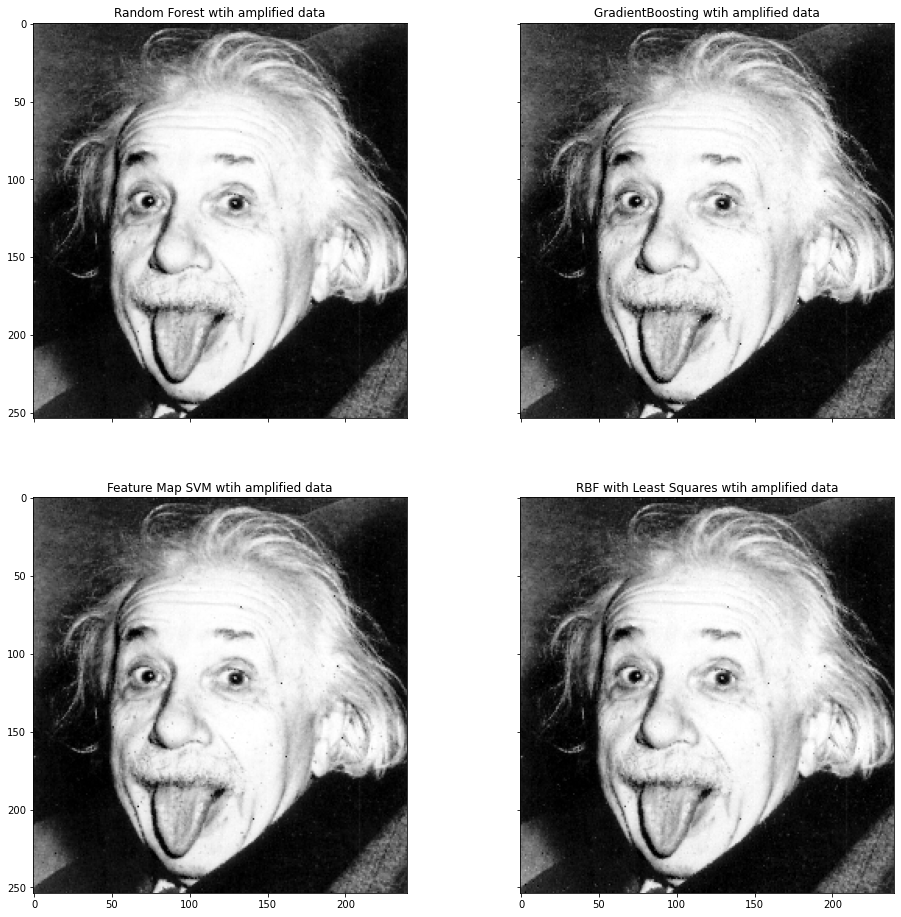

In [169]:
##################### Random Forest
RF_image = image_ss.copy()
k=0
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            RF_image[i][j]=RF_y_pred[k]
            k+=1
            

##################### GradientBoosting
GB_image = image_ss.copy()
k=0
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            GB_image[i][j]=GB_y_pred[k]
            k+=1

            
##################### SVM with RBF
SVR_image = image_ss.copy()
k=0
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            SVR_image[i][j]=SVR_y_pred[k]
            k+=1

##################### RBF with Least Squares
GKFMR_image = image_ss.copy()
k=0
for i in range(image_ss.shape[0]):
    for j in range(image_ss.shape[1]):
        if np.isnan(image_ss[i][j]):
            GKFMR_image[i][j]=GKFMR_y_pred[k]
            k+=1

                       
############ visualize the recovered image 
fig, axs = plt.subplots(2, 2, figsize=(16, 16), sharex=True, sharey=True)
axs[0,0].set_title('Random Forest wtih amplified data')
axs[0,0].imshow(RF_image, cmap='gray', vmin=0, vmax=255)
axs[0,1].set_title('GradientBoosting wtih amplified data')
axs[0,1].imshow(GB_image, cmap='gray', vmin=0, vmax=255)
axs[1,0].set_title('Feature Map SVM wtih amplified data')
axs[1,0].imshow(SVR_image, cmap='gray', vmin=0, vmax=255)
axs[1,1].set_title('RBF with Least Squares wtih amplified data')
axs[1,1].imshow(GKFMR_image, cmap='gray', vmin=0, vmax=255)
plt.show()

**Everybody looks good.**

# Question 2

### Implement B-Spline Feature Map here

In [266]:
"""
Robust B-Spline regression with scikit-learn
"""

def get_bspline_basis(knots, degree=3, periodic=False):
    """Get spline coefficients for each basis spline."""
    nknots = len(knots)
    y_dummy = np.zeros(nknots)

    knots, coeffs, degree = si.splrep(knots, y_dummy, k=degree,
                                      per=periodic)
    ncoeffs = len(coeffs)
    bsplines = []
    for ispline in range(nknots):
        coeffs = [1.0 if ispl == ispline else 0.0 for ispl in range(ncoeffs)]
        bsplines.append((knots, coeffs, degree))
    return bsplines


class BSplineFeatures(TransformerMixin):
    def __init__(self, knots, degree=3, periodic=False):
        self.bsplines = get_bspline_basis(knots, degree, periodic=periodic)
        self.nsplines = len(self.bsplines)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * self.nsplines))
        for ispline, spline in enumerate(self.bsplines):
            istart = ispline * nfeatures
            iend = (ispline + 1) * nfeatures
            features[:, istart:iend] = si.splev(X, spline)
        return features

# (a) 

### Implement a $\texttt{ExpKernelFeatures(locations,lambda=1)}$ class

In [267]:
# for the fit_transform() function to make it compatible with Pipeline
from sklearn.base import TransformerMixin 

# for the set_params() function to make it compatible with gridSearchCV
from sklearn.base import BaseEstimator 
class ExpKernelFeatures(TransformerMixin,BaseEstimator):
    # here the input location is a (k,) array
    # the input X is a (N,1) matrix
    # the exponential feature transform expands every row of X which contains 
    # a single entry (x_i) to a row vector containing k entris exp(−λ|x_i − l_j|)
    # where j ~ 1 to k 
    def __init__(self, locations=np.linspace(-2,2,10),lambd=1):
        self.lambd = lambd
        self.locations = locations  # actually just landmarks
        # But we still use self.locations here so it aligns with the argument
        # name 'location' to make ExpKernelFeatures compatible with 
        # gridsearchCV and Pipeline
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        nsamples, nfeatures = X.shape
        features = np.zeros((nsamples, nfeatures * len(self.locations)))
        for ilandmark, landmark in enumerate(self.locations):
            for i in range(nsamples):
                features[i][ilandmark]=np.exp(-self.lambd*abs(X[i]-landmark))
        return features
 

# (b) Plot the Exponential Kernel Features with lambda=4

(10000, 10)


Text(0.5, 1.0, 'Exponential Kernel Features with lambda=4')

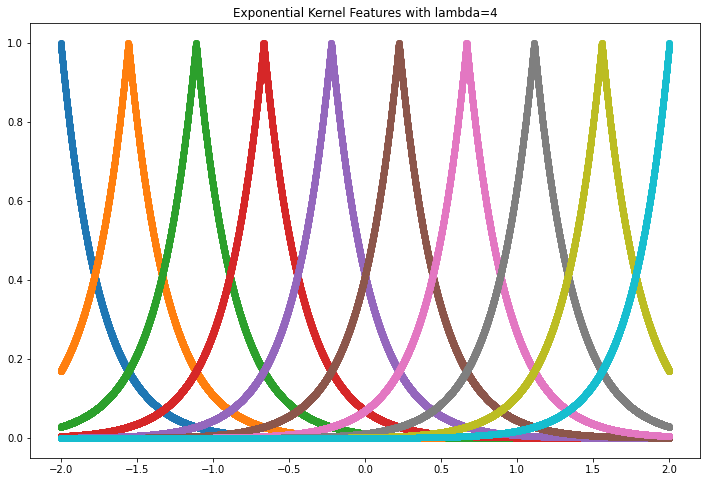

In [268]:
x_predict = np.linspace(-2,2,10000)
grid_points = np.linspace(-2,2,10)  # landmarks 

Exp_kf = ExpKernelFeatures(grid_points,lambd=4)
features = Exp_kf.fit_transform(x_predict[:,None])
print(features.shape)

plt.figure(figsize=(12,8))
plt.plot(x_predict, features,'o')
plt.title(f'Exponential Kernel Features with lambda=4')

# (c)

In [269]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as si
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, RANSACRegressor,\
                                 TheilSenRegressor, HuberRegressor


### On polynomial dataset & Compare with B-spline

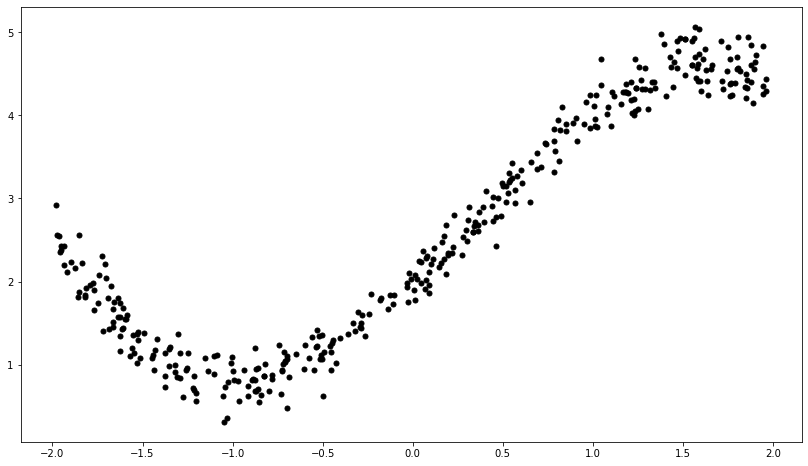

In [270]:
np.random.seed(42)

# X contains x-coordinates of the observations
X = np.random.uniform(low=-2, high=2, size=500)

model = 'polynomial'

if model == 'polynomial':
    y = 2. + 2 *X  + .4*X**2 - .4 * X**3
elif model == 'periodic':
    # Predicting function y=sin(2*pi*theta)
    y = np.sin(20 * np.pi * 0.1 * X)

# numpy.newaxis is used to increase the dimension of the existing array 
# by one more dimension, when used once.
X = X[:,np.newaxis] # from (N,) ----> (N,1)

# random normal error
error = 0.2 * np.random.randn(y.shape[0])

# generate observations with additive noise
y += error 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# x_predict contains the x-coordinates to make predictions
x_predict = np.linspace(-2, 2, 1000)


fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.plot(X_train, y_train, 'o', ms=5, c='black',
        label='data points [10% outliers]');

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: LinearRegression(fit_intercept=False) is {'ExpFeatures__lambd': 0.1} with optimal MSE CV score -0.04043466284008199 and MSE error 0.04443745690300843 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: TheilSenRegressor(max_subpopulation=10000, random_state=42) is {'ExpFeatures__lambd': 2} with optimal MSE CV score -0.052847095384508935 and MSE error 0.05437922403211336 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: RANSACRegressor(random_state=42) is {'ExpFeatures__lambd': 0.5} with optimal MSE CV score -0.040310762380789254 and MSE error 0.044471631225997066 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: HuberRegressor(max_iter=1000) is {'ExpFeatures__lambd': 0.1} with optimal MSE CV score -0.040673798477

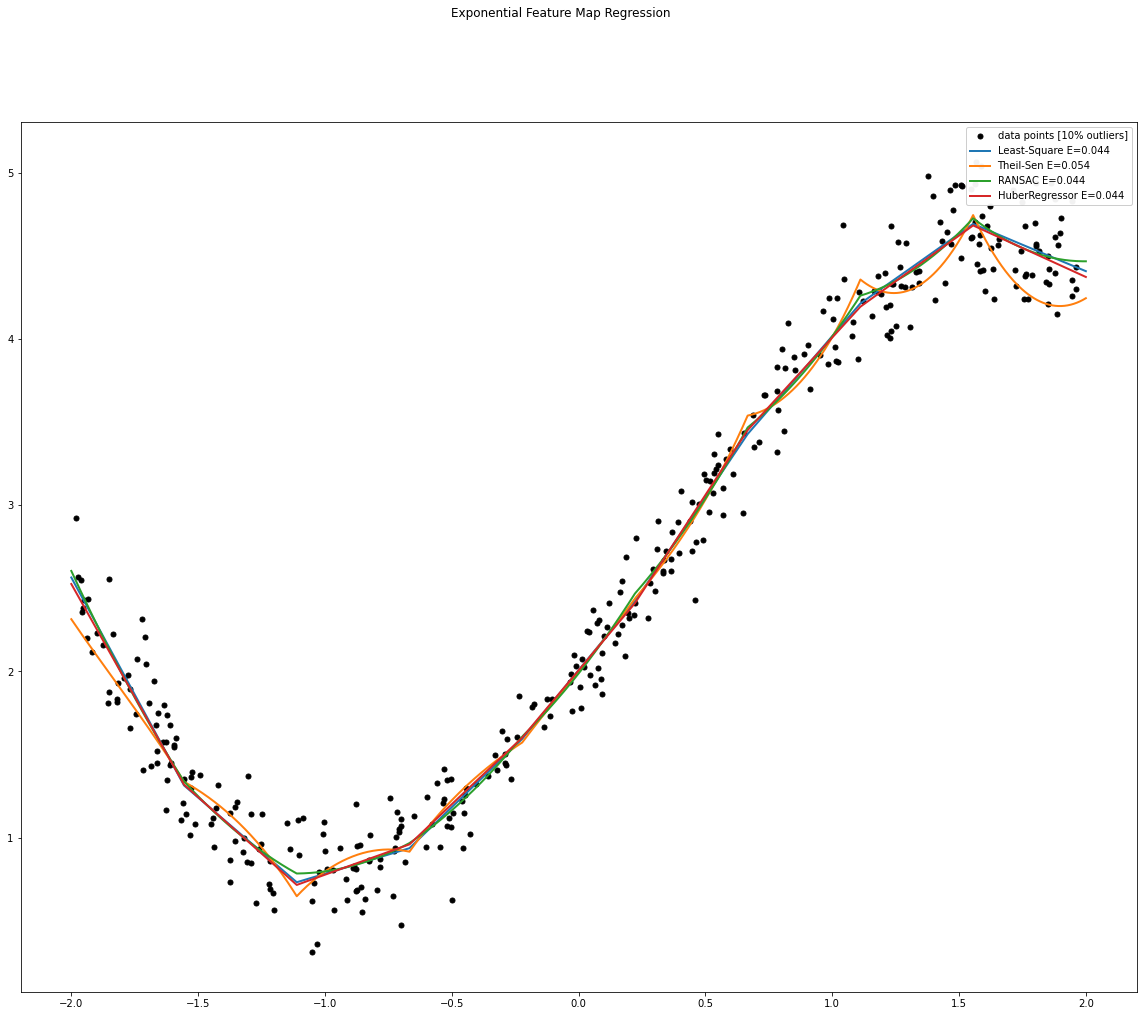

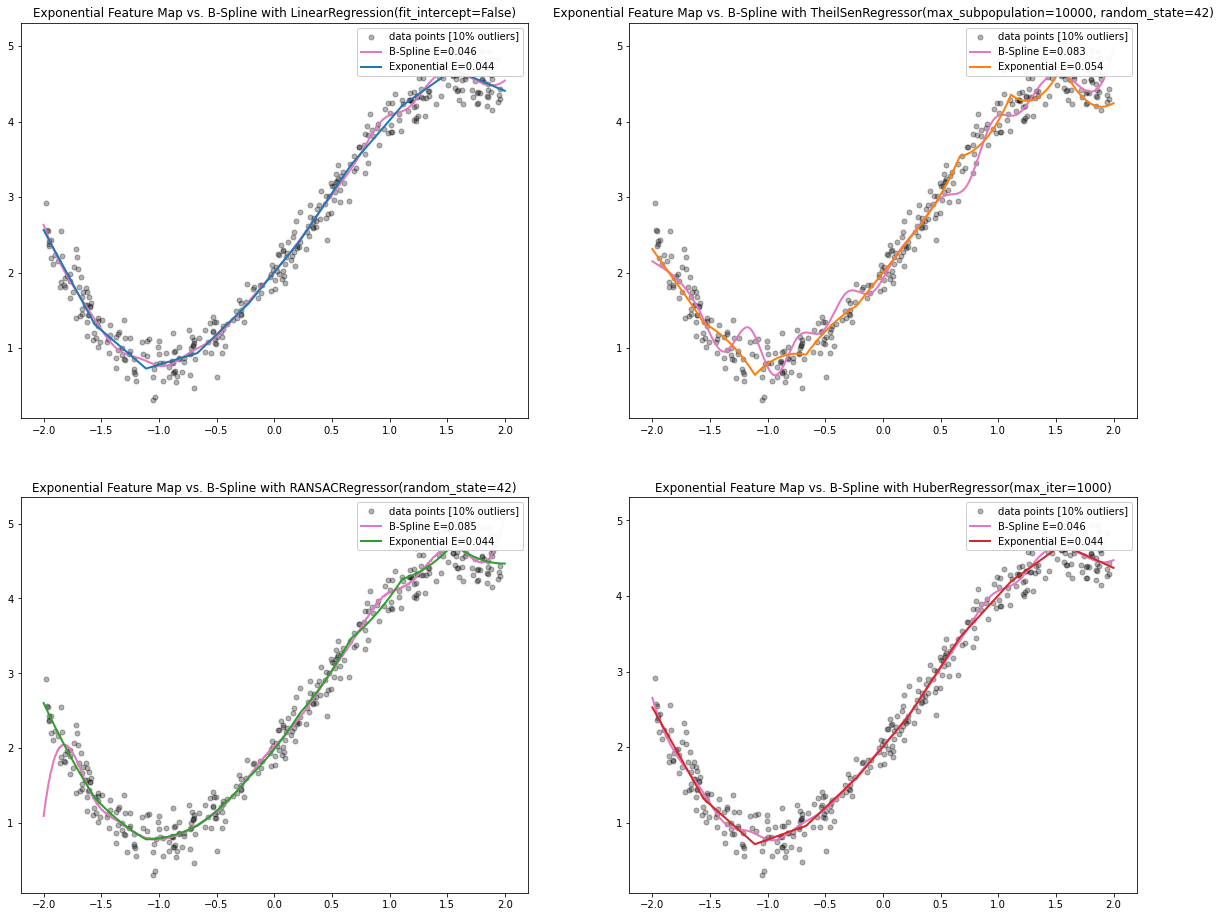

In [271]:
################### Set up the estimators
estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
              ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state=42)),
              ('RANSAC', '-', 'C2', RANSACRegressor(random_state=42)),
              ('HuberRegressor', '-', 'C3', HuberRegressor(max_iter=1000))]

################### Figure for Exponential Feature Map Regression
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
ax.plot(X_train, y_train, 'o', ms=5, c='black',
        label='data points [10% outliers]')

################### Figure for Comparing Exponential Feature Map vs B-Spline
fig2, axs = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Exponential Feature Map Regression')
axs[0,0].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
axs[0,1].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
axs[1,0].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]') 
axs[1,1].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
plot_i= 0  # For finding the right plot
plot_list=[(0,0), (0,1), (1,0), (1,1)]

for label, style, color, estimator in estimators:
    ################## Exponential Feature Map
    # Dictionary containing grid Hyperparameters
    grid_params = {
        'ExpFeatures__lambd': [0.1,0.5, 1,2,3,4,5]
    }

    # Build Pipeline
    gs_ExpFeatures = GridSearchCV(
        Pipeline([('ExpFeatures', ExpKernelFeatures(locations=grid_points)),
                  ('estimator', estimator)
        ]),
        grid_params,
        scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
        verbose = 1,  # set to 1 is equivalent to no bs
        cv = 5,       # (Stratified) 5-Fold Cross-Validation
        n_jobs=2      # use 2 processors
    )

    # Fit the train_set
    gs_ExpFeatures_results = gs_ExpFeatures.fit(X_train, y_train)
    
    # notes down the optimal score, optimal model and optimal lambda
    optimal_score=gs_ExpFeatures_results.best_score_
    optimal_lambda=gs_ExpFeatures_results.best_params_
    optimal_model=gs_ExpFeatures_results.best_estimator_
    
    # Compute the error between the values predicted by the optimal model
    # and true values (y_test) on the test set
    mse_exp = mean_squared_error(optimal_model.predict(X_test), y_test)
    #print(type(optimal_model))
    print(f'The optimal lambda for estimator: {estimator} is {optimal_lambda} with optimal MSE CV score {optimal_score} and MSE error {mse_exp} for the test set\n')
    
    # Compute the predicted y values for plotting
    y_predicted_exp = optimal_model.predict(x_predict[:, None])
    ix = np.argsort(x_predict)
    ax.plot(x_predict[ix], y_predicted_exp[ix], style, lw=2,
            color=color, label=label + ' E={:2.2g}'.format(mse_exp))
    
    ################## B-Spline Feature Map
    degree = 3
    knots = np.linspace(-2, 2, 20)
    bspline_features = BSplineFeatures(knots, degree=degree, periodic=False)
    bspline_model = make_pipeline(bspline_features, estimator)
    bspline_model.fit(X_train, y_train)
    bspline_mse = mean_squared_error(bspline_model.predict(X_test), y_test)
    y_predicted_bspline = bspline_model.predict(x_predict[:, None])
    
    # Plot the bspline fit and exponential fit in the same figure
    ix = np.argsort(x_predict)
    axs[plot_list[plot_i]].plot(x_predict[ix], y_predicted_bspline[ix], style, lw=2,
            color='C6', label='B-Spline' + ' E={:2.2g}'.format(bspline_mse))
    axs[plot_list[plot_i]].plot(x_predict[ix], y_predicted_exp[ix], style, lw=2,
            color=color, label='Exponential' + ' E={:2.2g}'.format(mse_exp))
    axs[plot_list[plot_i]].legend(loc='upper right', framealpha=0.95)
    axs[plot_list[plot_i]].set_title(f'Exponential Feature Map vs. B-Spline with {estimator}')
    plot_i = plot_i + 1
    
ax.legend(loc='upper right', framealpha=0.95)
plt.show()

We see that **for the polynomial dataset**, the Exponential Feature Map Regression fit **is very similar, nearly identical, to** the B-Spline features fit.

### On periodic dataset Compare with B-spline

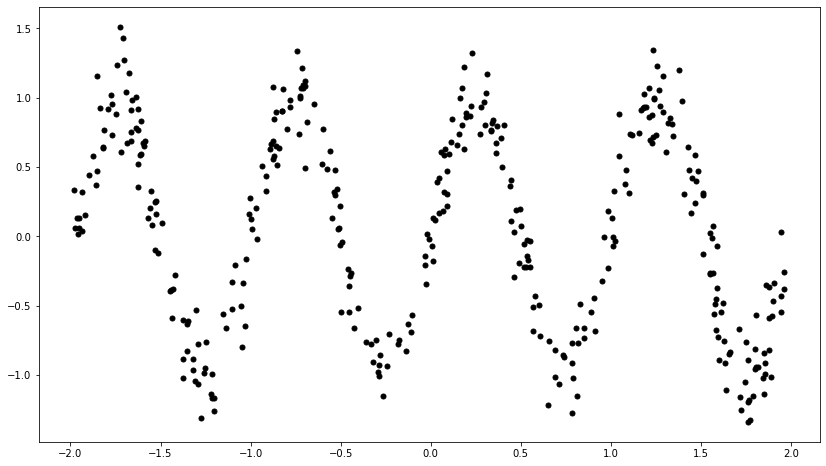

In [272]:
np.random.seed(42)

# X contains x-coordinates of the observations
X = np.random.uniform(low=-2, high=2, size=500)

model = 'periodic'

if model == 'polynomial':
    y = 2. + 2 *X  + .4*X**2 - .4 * X**3
elif model == 'periodic':
    # Predicting function y=sin(2*pi*theta)
    y = np.sin(20 * np.pi * 0.1 * X)

# numpy.newaxis is used to increase the dimension of the existing array 
# by one more dimension, when used once.
X = X[:,np.newaxis] # from (N,) ----> (N,1)

# random normal error
error = 0.2 * np.random.randn(y.shape[0])

# generate observations with additive noise
y += error 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# x_predict contains the x-coordinates to make predictions
x_predict = np.linspace(-2, 2, 1000)


fig, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.plot(X_train, y_train, 'o', ms=5, c='black',
        label='data points [10% outliers]');

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: LinearRegression(fit_intercept=False) is {'ExpFeatures__lambd': 0.1} with optimal MSE CV score -0.14992603720546233 and MSE error 0.1561138831984905 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: TheilSenRegressor(max_subpopulation=10000, random_state=42) is {'ExpFeatures__lambd': 2} with optimal MSE CV score -0.18404167029103152 and MSE error 0.18040168534834808 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: RANSACRegressor(random_state=42) is {'ExpFeatures__lambd': 1} with optimal MSE CV score -0.2520769265481731 and MSE error 1.0725616030028495 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: HuberRegressor(max_iter=1000) is {'ExpFeatures__lambd': 0.1} with optimal MSE CV score -0.15365668281759595 an

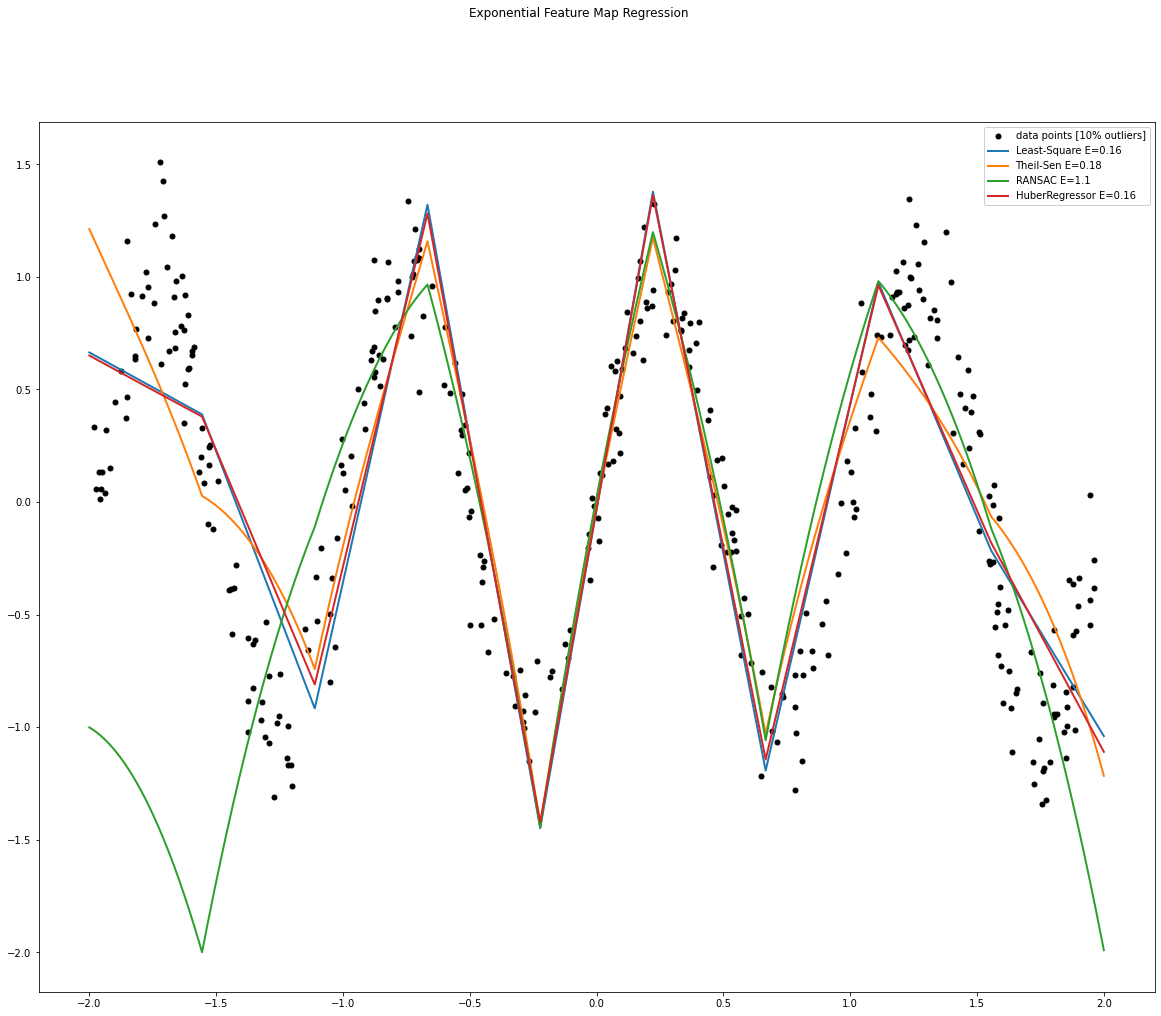

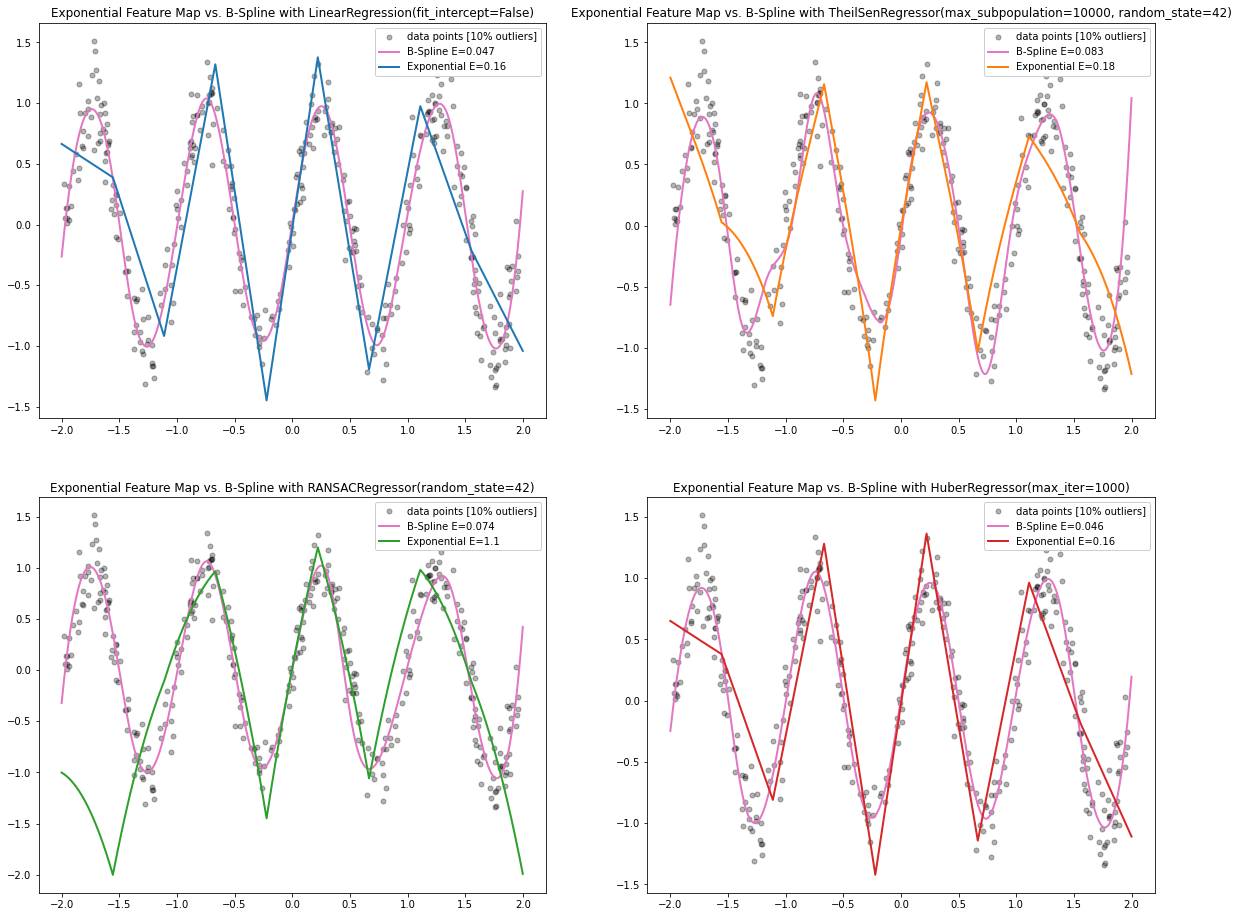

In [273]:
################### Set up the estimators
estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
              ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state=42)),
              ('RANSAC', '-', 'C2', RANSACRegressor(random_state=42)),
              ('HuberRegressor', '-', 'C3', HuberRegressor(max_iter=1000))]

################### Figure for Exponential Feature Map Regression
fig, ax = plt.subplots(1, 1, figsize=(20, 16))
fig.suptitle('Exponential Feature Map Regression')
ax.plot(X_train, y_train, 'o', ms=5, c='black',
        label='data points [10% outliers]')

################### Figure for Comparing Exponential Feature Map vs B-Spline
fig2, axs = plt.subplots(2, 2, figsize=(20, 16))
axs[0,0].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
axs[0,1].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
axs[1,0].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]') 
axs[1,1].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
plot_i= 0  # For finding the right plot
plot_list=[(0,0), (0,1), (1,0), (1,1)]

for label, style, color, estimator in estimators:
    ################## Exponential Feature Map
    # Dictionary containing grid Hyperparameters
    grid_params = {
        'ExpFeatures__lambd': [0.1,0.5, 1,2,3,4,5]
    }

    # Build Pipeline
    gs_ExpFeatures = GridSearchCV(
        Pipeline([('ExpFeatures', ExpKernelFeatures(locations=grid_points)),
                  ('estimator', estimator)
        ]),
        grid_params,
        scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
        verbose = 1,  # set to 1 is equivalent to no bs
        cv = 5,       # (Stratified) 5-Fold Cross-Validation
        n_jobs=2      # use 2 processors
    )

    # Fit the train_set
    gs_ExpFeatures_results = gs_ExpFeatures.fit(X_train, y_train)
    
    # notes down the optimal score, optimal model and optimal lambda
    optimal_score=gs_ExpFeatures_results.best_score_
    optimal_lambda=gs_ExpFeatures_results.best_params_
    optimal_model=gs_ExpFeatures_results.best_estimator_
    
    # Compute the error between the values predicted by the optimal model
    # and true values (y_test) on the test set
    mse_exp = mean_squared_error(optimal_model.predict(X_test), y_test)
    #print(type(optimal_model))
    print(f'The optimal lambda for estimator: {estimator} is {optimal_lambda} with optimal MSE CV score {optimal_score} and MSE error {mse_exp} for the test set\n')
    
    # Compute the predicted y values for plotting
    y_predicted_exp = optimal_model.predict(x_predict[:, None])
    ix = np.argsort(x_predict)
    ax.plot(x_predict[ix], y_predicted_exp[ix], style, lw=2,
            color=color, label=label + ' E={:2.2g}'.format(mse_exp))
    
    ################## B-Spline Feature Map
    degree = 3
    knots = np.linspace(-2, 2, 20)
    bspline_features = BSplineFeatures(knots, degree=degree, periodic=False)
    bspline_model = make_pipeline(bspline_features, estimator)
    bspline_model.fit(X_train, y_train)
    bspline_mse = mean_squared_error(bspline_model.predict(X_test), y_test)
    y_predicted_bspline = bspline_model.predict(x_predict[:, None])
    
    # Plot the bspline fit and exponential fit in the same figure
    ix = np.argsort(x_predict)
    axs[plot_list[plot_i]].plot(x_predict[ix], y_predicted_bspline[ix], style, lw=2,
            color='C6', label='B-Spline' + ' E={:2.2g}'.format(bspline_mse))
    axs[plot_list[plot_i]].plot(x_predict[ix], y_predicted_exp[ix], style, lw=2,
            color=color, label='Exponential' + ' E={:2.2g}'.format(mse_exp))
    axs[plot_list[plot_i]].legend(loc='upper right', framealpha=0.95)
    axs[plot_list[plot_i]].set_title(f'Exponential Feature Map vs. B-Spline with {estimator}')
    plot_i = plot_i + 1
    
ax.legend(loc='upper right', framealpha=0.95)
plt.show()

We see that **for the periodic dataset**, the the B-Spline features fit **always performs better** than the Exponential Feature Map Regression fit.

# (d)

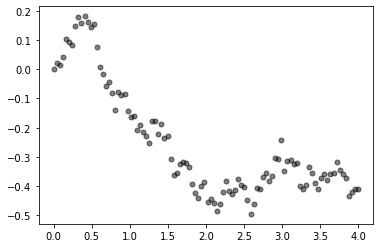

In [294]:
np.random.seed(42)
time = np.linspace(0, 4, 100)
delta = time[1]-time[0]

# Construct a Brownian Motion 
W = np.zeros(100)
for i in range(1,100):
    W[i] = W[i-1] + np.random.normal(loc=0, scale=delta)

plt.plot(time, W,'o', ms=5, color='black', alpha=0.5)

Looks good!

### Split the Dataset to TrainSet and TestSet for fitting the Regression Models

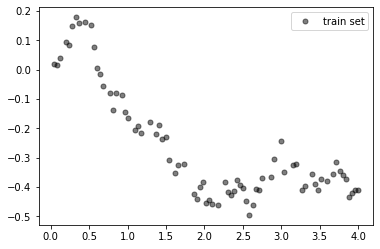

In [300]:
# numpy.newaxis is used to increase the dimension of the existing array 
# by one more dimension, when used once.
X = time[:,np.newaxis] # from (N,) ----> (N,1)
y = W

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# x_predict contains the x-coordinates to make predictions
x_predict = np.linspace(0, 4, 1000)

## Check the trainset, should look similar to the 
plt.plot(X_train, y_train,'o', ms=5, color='black', alpha=0.5, label='train set')
plt.legend()

For the number of landmarks for the Exponential Feature Map K=5:
Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: LinearRegression(fit_intercept=False) is {'ExpFeatures__lambd': 0.1} with optimal MSE CV score -0.0031863981794894385 and MSE error 0.0032594342192285275 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: TheilSenRegressor(max_subpopulation=10000, random_state=42) is {'ExpFeatures__lambd': 0.5} with optimal MSE CV score -0.005108313276722643 and MSE error 0.003707634935658181 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: RANSACRegressor(min_samples=0.75, random_state=42) is {'ExpFeatures__lambd': 0.1} with optimal MSE CV score -0.0039082011083076615 and MSE error 0.0037562211223880577 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: HuberRegre

/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

The optimal lambda for estimator: HuberRegressor(max_iter=10000) is {'ExpFeatures__lambd': 0.1} with optimal MSE CV score -0.00147890625573791 and MSE error 0.0008296023355245873 for the test set

For the number of landmarks for the Exponential Feature Map K=100:
Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: LinearRegression(fit_intercept=False) is {'ExpFeatures__lambd': 5} with optimal MSE CV score -0.0013901416379382748 and MSE error 0.0008912628032198948 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: TheilSenRegressor(max_subpopulation=10000, random_state=42) is {'ExpFeatures__lambd': 5} with optimal MSE CV score -0.0013796259107502246 and MSE error 0.0008765285263376381 for the test set

Fitting 5 folds for each of 7 candidates, totalling 35 fits
The optimal lambda for estimator: RANSACRegressor(min_samples=0.75, random_state=42) is {'ExpFeatures__lambd': 5} with optimal

/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/zhoukaiwen/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERAT

The optimal lambda for estimator: HuberRegressor(max_iter=10000) is {'ExpFeatures__lambd': 0.1} with optimal MSE CV score -0.0013664151393817966 and MSE error 0.0007054155598634918 for the test set



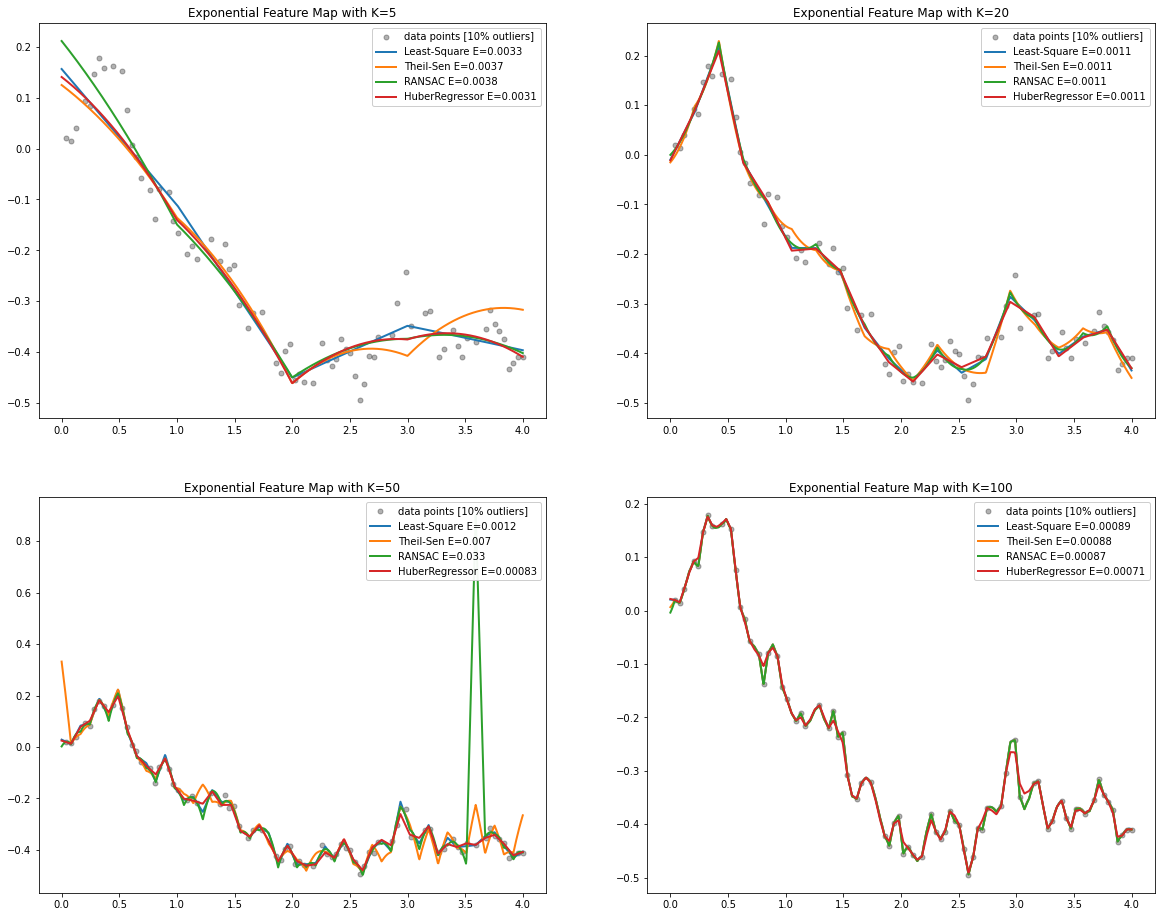

In [302]:
################### Set up the estimators
estimators = [('Least-Square', '-', 'C0', LinearRegression(fit_intercept=False)),
              ('Theil-Sen', '-', 'C1', TheilSenRegressor(random_state=42)),
              ('RANSAC', '-', 'C2', RANSACRegressor(random_state=42, min_samples=0.75)),
              ('HuberRegressor', '-', 'C3', HuberRegressor(max_iter=10000))]

############# Figures for Comparing Exponential Feature Map with different K's
"""Here K is the number of landmarks (i.e.location points)"""
fig2, axs = plt.subplots(2, 2, figsize=(20, 16))
axs[0,0].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
axs[0,1].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
axs[1,0].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]') 
axs[1,1].plot(X_train, y_train, 'o', ms=5, c='black', alpha=0.3,
        label='data points [10% outliers]')
plot_i= 0  # For finding the right plot
plot_list=[(0,0), (0,1), (1,0), (1,1)]

for K in [5, 20, 50, 100]:
    # Set up the landmarks for the Exponential Feature Map
    K_grid_points=np.linspace(0,4,K)
    print(f'For the number of landmarks for the Exponential Feature Map K={K}:')
    
    for label, style, color, estimator in estimators:
        ################## Exponential Feature Map
        # Dictionary containing grid Hyperparameters
        grid_params = {
            'ExpFeatures__lambd': [0.1,0.5,1,2,3,4,5]
        }

        # Build Pipeline
        gs_ExpFeatures = GridSearchCV(
            Pipeline([('ExpFeatures', ExpKernelFeatures(locations=K_grid_points)),
                      ('estimator', estimator)
            ]),
            grid_params,
            scoring = 'neg_mean_squared_error', # the value is negated intentionally by sklearn
            verbose = 1,  # set to 1 is equivalent to no bs
            cv = 5,       # (Stratified) 5-Fold Cross-Validation
            n_jobs=2      # use 2 processors
        )
        
        # Fit the train_set
        gs_ExpFeatures_results = gs_ExpFeatures.fit(X_train, y_train)

        # notes down the optimal score, optimal model and optimal lambda
        optimal_score=gs_ExpFeatures_results.best_score_
        optimal_lambda=gs_ExpFeatures_results.best_params_
        optimal_model=gs_ExpFeatures_results.best_estimator_

        # Compute the error between the values predicted by the optimal model
        # and true values (y_test) on the test set
        mse_exp = mean_squared_error(optimal_model.predict(X_test), y_test)
        
        print(f'The optimal lambda for estimator: {estimator} is {optimal_lambda} with optimal MSE CV score {optimal_score} and MSE error {mse_exp} for the test set\n')

        # Compute the predicted y values for plotting
        y_predicted_exp = optimal_model.predict(x_predict[:, None])
        ix = np.argsort(x_predict)
        axs[plot_list[plot_i]].plot(x_predict[ix], y_predicted_exp[ix], style, lw=2,
                color=color, label=label + ' E={:2.2g}'.format(mse_exp))

    ################## 
    axs[plot_list[plot_i]].legend(loc='upper right', framealpha=0.95)
    axs[plot_list[plot_i]].set_title(f'Exponential Feature Map with K={K}')
    plot_i = plot_i + 1

plt.show()

We can see that **generally my fit improves as K becomes larger except for K=50, where TheilSenRegressor and RANSACRegressor become slightly worse.**